In [275]:
# THERE IS A DEMO PLOT AT THE END OF THE NOTEBOOK
# If you're trying it out, then run the first two cells. 
# The first one is for imports, and the second one defines some global variables

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import datetime as dt

In [4]:
COLORS = ['#0984e3', '#00b894', '#eb4d4b' , '#00cec9', '#7158e2', '#d63031', '#fa8231', '#0a3d62', '#009688']

data = 'WHO-COVID-19-global-data.csv'
df = pd.read_csv(data)

In [5]:
def get_country_df(country):
    df.columns = [i.strip() for i in df.columns]
    df.rename(columns={'Date_reported' : 'Date'}, inplace = True)
    df['Date'] = pd.to_datetime(df['Date'])
    country_groups = df.groupby('Country')
    country_df = country_groups.get_group(country)
    return country_df

In [6]:
def get_cases(country, how = 'New_cases', start_date = None, end_date = None):
    country_df = get_country_df(country)
    country_df.set_index('Date', inplace = True)

    if start_date is None:
        filt = country_df[how] >= 1

        country_df = country_df[filt]
    
        return country_df.loc[:, [how]]
    
    else:
        return country_df.loc[start_date:end_date, [how]]

In [7]:
def get_deaths(country, how = 'New_deaths', start_date = None, end_date = None):
    country_df = get_country_df(country)
    country_df.set_index('Date', inplace = True)

    if start_date is None:

        filt = country_df[how] >= 1

        country_df = country_df[filt]

        return country_df.loc[:, [how]]

    else:
        return country_df.loc[start_date:end_date, [how]]

In [8]:
def get_country_dictionary(countries, plot, plot_type = 'line', animate=False, start_date = None, end_date = None):
    country_dictionary = {}
    
    for i in countries:
        if plot.lower() == "new cases":
            if plot_type != 'bar':
                country_dictionary[i] = get_cases(i)
            elif plot_type == 'bar' or animate:
                country_dictionary[i] = get_cases(i, start_date=start_date, end_date=end_date)
        
        elif plot.lower() == 'total cases':
            if plot_type != 'bar':
                country_dictionary[i] = get_cases(i, 'Cumulative_cases')
                
            elif plot_type == 'bar' or animate:
                country_dictionary[i] = get_cases(i, 'Cumulative_cases', start_date=start_date, end_date=end_date)
            
        elif plot.lower() == 'new deaths':
            if plot_type != 'bar':
                country_dictionary[i] = get_deaths(i)
            
            elif plot_type == 'bar' or animate:
                country_dictionary[i] = get_deaths(i, start_date=start_date, end_date=end_date)
            
        elif plot.lower() == 'total deaths':
            if plot_type != 'bar':
                country_dictionary[i] = get_deaths(i, 'Cumulative_deaths') 
            elif plot_type == 'bar' or animate:
                country_dictionary[i] = get_deaths(i, 'Cumulative_deaths', start_date=start_date, end_date=end_date)
                
       
    country_dictionary = {
        key: country_dictionary[key] 
        for key in sorted(country_dictionary, key = lambda k: len(country_dictionary[k]))
    }
        
    return country_dictionary

In [9]:
def plot_data(countries, plot = 'new cases', plot_type = 'line'):
    
    if not (isinstance(countries, list) or isinstance(countries, tuple)):
        raise TypeError("Please pass in a list/tuple of Country/Countries")
        return
    
    # country comes in as a list
     
    %matplotlib notebook    
    plt.style.use('seaborn-colorblind')
    
    if plot_type == 'line':
        fig, (ax1) = plt.subplots(1,1, figsize=(10, 5))
        axes = [ax1]
    
    else:
        num = len(countries) // 2 if len(countries) % 2 == 0 else len(countries) // 2 + 1
        
        fig, all_axis_objs = plt.subplots(num, 2, figsize=(10, 2.5 * num))
        
        axes = []
        
        for i in range(all_axis_objs.shape[0]):
            for j in range(all_axis_objs.shape[1]):
                axes.append(all_axis_objs[i][j])

        axes = axes if len(countries) % 2 == 0 else axes[:-1]
   
    
    country_dictionary = get_country_dictionary(countries, plot, plot_type = 'line')
    
    
    keys = list(country_dictionary.keys())

    country_name = []
    country_data_x = []
    country_data_y = []
     
    for country in countries:   
        dates = country_dictionary[country].index
        
        country_name.append(country)
        country_data_x.append(dates)
        
        if plot.lower() == "new cases":
            country_data_y.append(country_dictionary[country]['New_cases'])
        
        elif plot.lower() == 'total cases':
            country_data_y.append(country_dictionary[country]['Cumulative_cases'])
            
        elif plot.lower() == 'new deaths':
            country_data_y.append(country_dictionary[country]['New_deaths'])
            
        elif plot.lower() == 'total deaths':
            country_data_y.append(country_dictionary[country]['Cumulative_deaths'])
        
    
    colori = 0

    if plot_type == 'line':
        to_add = '/Day' if 'new' in plot else ''

        axes[0].set_title(f"{plot.split(' ')[0].upper()} COVID-19 {plot.split(' ')[1].upper()}{to_add}")

        axes[0].set_ylabel(plot.upper())
        axes[0].set_xlabel('Month of 2020')
        axes[0].tick_params(axis='x', rotation=35)

        for index, data in enumerate(country_data_x):
            axes[0].plot(
                country_data_x[index], 
                country_data_y[index], 
                label = country_name[index],
                color = COLORS[colori],
                alpha = 0.75
            )
            
            colori = 0 if (colori + 1 == len(COLORS)) else (colori + 1)


        axes[0].legend(loc = 'upper left')


    else:
        for index, axis in enumerate(axes):
            if index < len(country_data_x):
                axis.set_title(country_name[index])
                axis.set_ylabel(plot.upper())
                axis.set_xlabel('Month of 2020')

                axis.bar(
                    country_data_x[index], 
                    country_data_y[index], 
                    color = COLORS[colori],
                    width = 0.6, alpha = 0.75
                )

                axis.tick_params(axis = 'x', rotation = 35)
            
            colori = 0 if (colori + 1 == len(COLORS)) else (colori + 1)
            
    fig.tight_layout(pad = 3.0)


In [16]:
def plot_all_data_for_a_country(country, plot_type = 'line'):
    if not isinstance(country, str):
        raise ValueError("Please input only one country as a string.")
        return 
    
    # the below variables are data frames
    
    new_cases = get_cases(country)['New_cases']
    total_cases = get_cases(country, how = 'Cumulative_cases')['Cumulative_cases']
    new_deaths = get_deaths(country)['New_deaths']
    total_deaths = get_deaths(country, how = 'Cumulative_deaths')['Cumulative_deaths']

    
    dates = [new_cases.index, total_cases.index, new_deaths.index, total_deaths.index]
    to_plot = [new_cases, total_cases, new_deaths, total_deaths]
    labels = ['New Cases / Day', 'Total Cases', 'New Deaths / Day', 'Total Deaths']
    %matplotlib notebook
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10,5))
    fig.suptitle(f"Stats for {country}")
    axes = [ax1, ax2, ax3, ax4]
    colori = 0
    for index, axis in enumerate(axes):
        axis.set_title(labels[index])
        axis.tick_params(axis='x', rotation=35)
        axis.set_xlabel("Month of 2020")
        y = labels[index].split('/')[0]
        axis.set_ylabel(y)
        
        if plot_type == 'line':
            axis.plot(dates[index], to_plot[index], color = COLORS[colori])
            
        if plot_type == 'bar':
            axis.bar(dates[index], to_plot[index], color = COLORS[colori], width = 0.6)
            
        colori = 0 if (colori + 1 == len(COLORS)) else (colori + 1)
    
    fig.tight_layout(pad = 3.0)
    
        

In [32]:
def get_data_for_pie(date, plot, all_plots):
    number = 5 if all_plots else 10
    
    df1 = pd.read_csv(data)

    df1.rename(columns = {'Date_reported' : "Date"}, inplace = True)
    df1.columns = [i.strip() for i in df1.columns]
    
    d = {
        'total cases' : "Cumulative_cases",
        'new cases' : 'New_cases',
        'total deaths' : 'Cumulative_deaths',
        'new deaths' : 'New_deaths'
    }
    keys = [i for i in d.keys()]
    cases_list = []
    labels_list = []
    
    new_df = df1.groupby("Date").get_group(date).sort_values(by = d[plot], ascending = False)

    all_cases = new_df[d[plot]]
    cases = all_cases / np.sum(all_cases)
    cases = np.append(cases[:number],np.sum(cases[number:]))
    
    labels = new_df['Country_code'][:number]
    labels = np.append(labels, np.array(['others']))
    
    labels_c = new_df['Country'][:number]
    
    labels = {code:country for (code, country) in zip(labels, labels_c)}
    labels['others'] = 'others'
    
    return np.sum(all_cases[:number]), cases, labels

In [44]:
def plot_pie(date, plot = 'total cases', all_plots = False):
        
    if not all_plots:
        fonts = {'verticalalignment': 'bottom',
                 'horizontalalignment': 'left'}
        
        sum_all_cases, cases, labels_dict = get_data_for_pie(date, plot, all_plots)
        labels = [code for code in labels_dict.keys()]
        fig, axis = plt.subplots(1,1, figsize=(10,5))
        
        plt.rc('font', size = 8)
        plt.style.use('seaborn-colorblind')
        
        axis.text(-3,-1.5,s = f'Total Shared Cases = {sum_all_cases}')
        axis.set_title(f'Percentage of {plot.upper()} shared by Top 10 Countries on {date}', pad = 30.0)
        axis.pie(cases, labels = labels, autopct='%1.0f%%', pctdistance = 0.9, radius = 1.3, textprops={'size': 'smaller'});
        
        legend = ''
        
        for k, v in labels_dict.items():
            legend += f"{k}    : {v}\n" 
            
        axis.text(-3,0.2,s=legend)
        
    else:
        keys = ['total cases', 'new cases', 'total deaths', 'new deaths']
        print(keys)
        sum_all_cases_list, cases_list, labels_list = [], [], []
        
        for key in keys:
            sum_all_cases, cases, labels = get_data_for_pie(date, plot = key, all_plots = all_plots)
            
            sum_all_cases_list.append(sum_all_cases)
            cases_list.append(cases)
            labels_list.append(labels)
            
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10, 5))
        plt.rc('font', size=6.5)
        plt.style.use('seaborn-colorblind')

        axes = [ax1, ax2, ax3, ax4]
        
        for index, axis in enumerate(axes):
            axis.set_title(f'% {keys[index].upper()} shared by Top 5 Countries on {date}')
            axis.pie(cases_list[index], labels = labels_list[index], autopct = '%1.0f%%', pctdistance=0.8)

In [77]:
def get_sum_col(col = 'New_cases'):
    
    df = pd.read_csv(data)
    
    df.columns = [i.strip() for i in df.columns]
    
    df.rename(columns = {'Date_reported' : "Date"}, inplace = True)
    
    dates = df['Date'].unique()
    
    date_groups = df.groupby('Date')
    
    lst = []
    
    for date in dates:
        lst.append(date_groups.get_group(date)[col].sum())
        
    return pd.to_datetime(np.array(dates)), np.array(lst)

In [163]:
def plot_global_data(plot = 'new cases', plot_type = 'line', plot_all=False):
    
    dates, y, new_cases, total_cases, new_deaths, total_deaths = [None] * 6
    
    if plot_all is False:
        if plot.lower() == 'new cases':
            dates, y = get_sum_col('New_cases')

        elif plot.lower() == 'total cases':
            dates, y = get_sum_col('Cumulative_cases')

        elif plot.lower() == 'new deaths':
            dates, y = get_sum_col('New_deaths')

        elif plot.lower() == 'total deaths':
            dates, y = get_sum_col('Cumulative_deaths')
            
    else:
        dates, new_cases = get_sum_col('New_cases')
        _, total_cases   = get_sum_col('Cumulative_cases')
        _, new_deaths    = get_sum_col('New_deaths')
        _, total_deaths  = get_sum_col('Cumulative_deaths')
        
        all_data = [new_cases, total_cases, new_deaths, total_deaths]
        titles = ["New Cases / Day", "Total Cases", "New Deaths / Day", "Total Deaths"]
    
    %matplotlib notebook
    
    if not plot_all:
        fig, (ax1) = plt.subplots(1,1,figsize=(10, 5))

        ax1.set_xlabel("Month of 2020")
        ax1.tick_params(axis='x', rotation=35)

        t = [i.upper() for i in plot.split(" ")]
        
        to_add = ' / Day' if t[0] == 'NEW' else ''
  
        
        if t[0] == 'NEW':
            max_i = np.argmax(y)
            min_i = np.argmin(y)
            
            maximum = y[max_i]
            minimum = y[min_i]
            date_max = dates[max_i]
            date_min = dates[min_i]
        
        ax1.set_title(f"Global {t[0]} COVID-19 {t[1]} {to_add}")
        
        ax1.set_ylabel(f"{t[0]} {t[1]}")
        
        
        ax1.scatter(date_min,minimum, label = f"{minimum} {t[1]} on {str(date_min)[:11]}", alpha = 0.75)
        ax1.scatter(date_max,maximum, label = f"{maximum} {t[1]} on {str(date_max)[:11]}", alpha = 0.75)
        
        if plot_type == 'line':
            ax1.plot(dates, y, color = COLORS[0], alpha = 0.75)
            
        else:
            ax1.bar(dates, y, color = COLORS[0], alpha = 0.75, width = 0.6)
        
        ax1.legend()
        fig.tight_layout(pad = 3.0)
        
    else:
        # plot all
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(10,5))
        
        axes = [ax1, ax2, ax3, ax4]
        
        for index, axis in enumerate(axes):
            axis.set_title('Global ' + titles[index])
            axis.set_ylabel(titles[index].split('/')[0])
            axis.tick_params(axis = 'x', rotation = 35)
            axis.set_xlabel('Month of 2020')
            
            if plot_type == 'line':
                axis.plot(dates, all_data[index], color = COLORS[index], alpha = 0.75)

            else:
                axis.bar(dates, all_data[index], color = COLORS[index], alpha = 0.75, width = 0.5)
            
        fig.tight_layout(pad = 2.0)
    
    

<IPython.core.display.Javascript object>


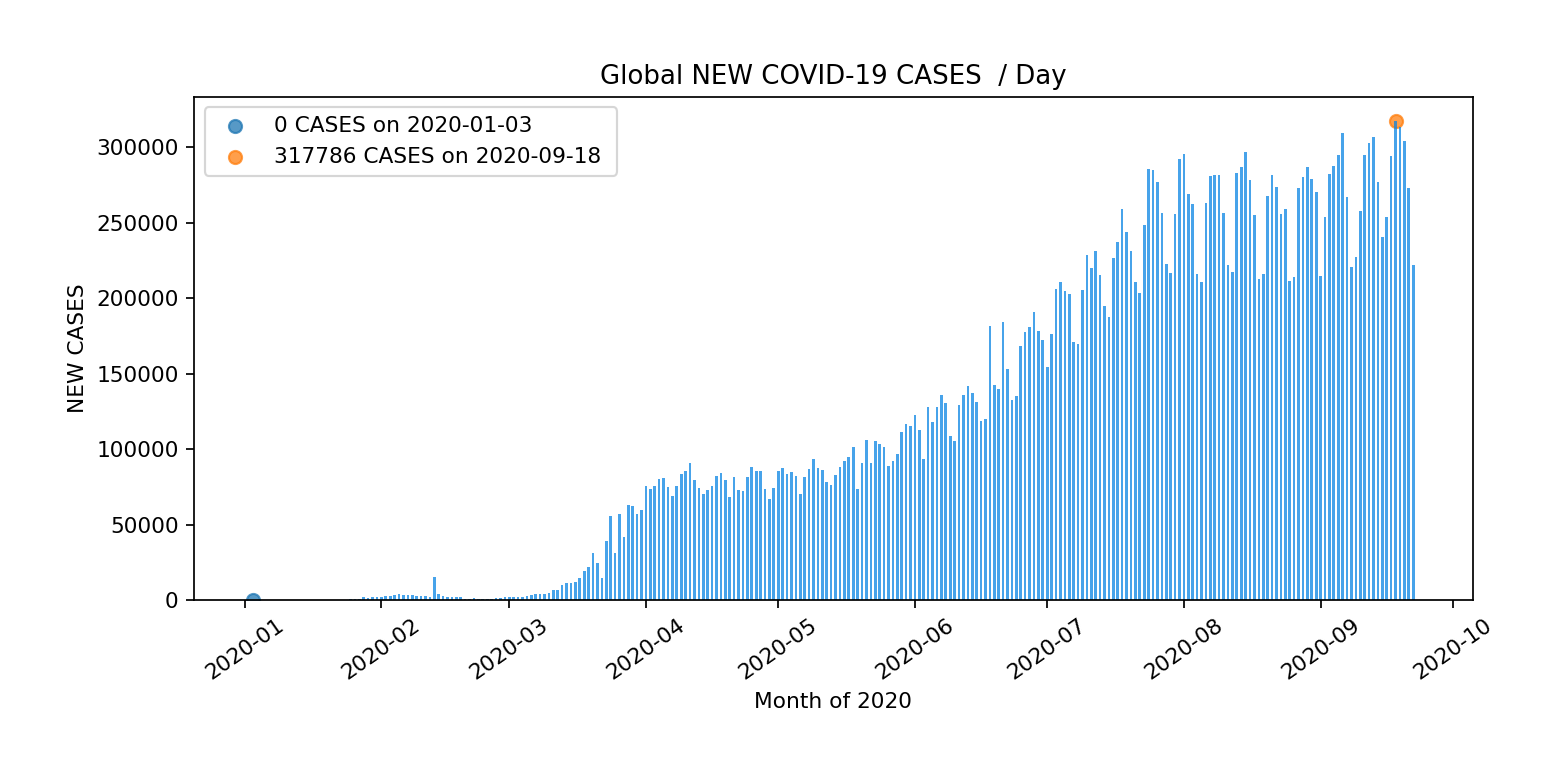

In [167]:
plot_global_data(plot_type = 'bar')

<IPython.core.display.Javascript object>


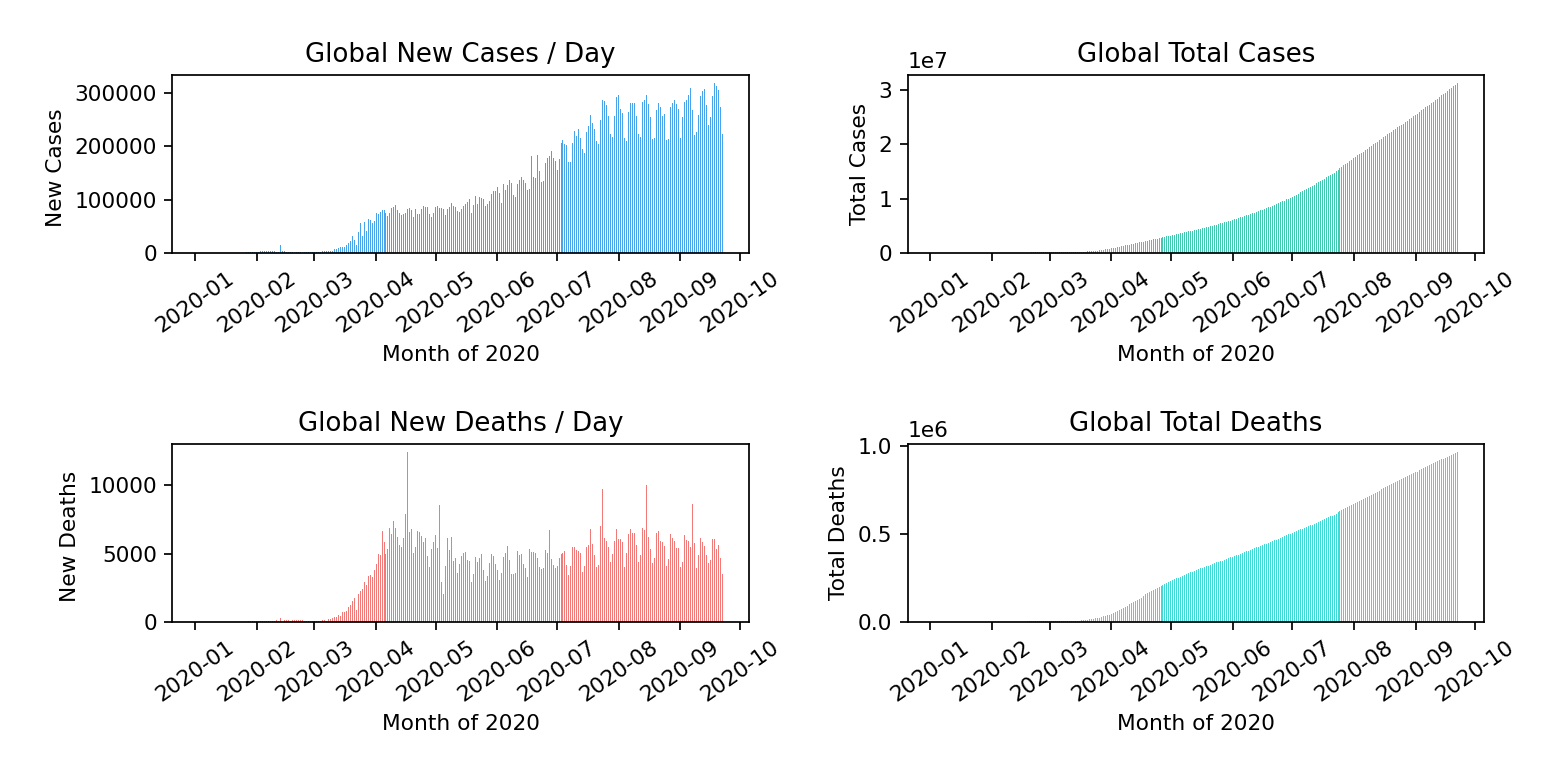

In [168]:
plot_global_data(plot_type = 'bar', plot_all = True)

<IPython.core.display.Javascript object>


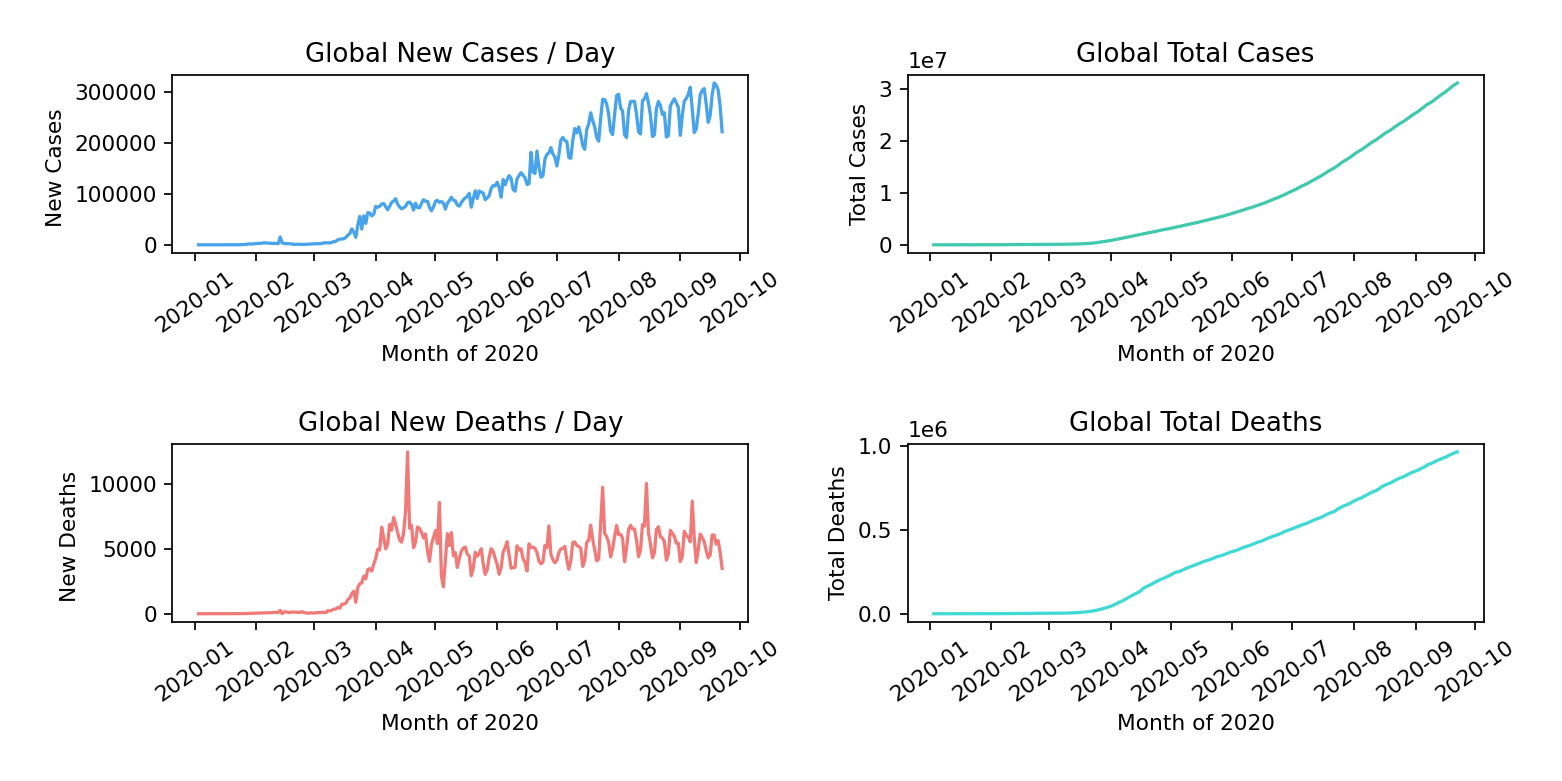

In [169]:
plot_global_data(plot_type = 'line', plot_all = True)

<IPython.core.display.Javascript object>


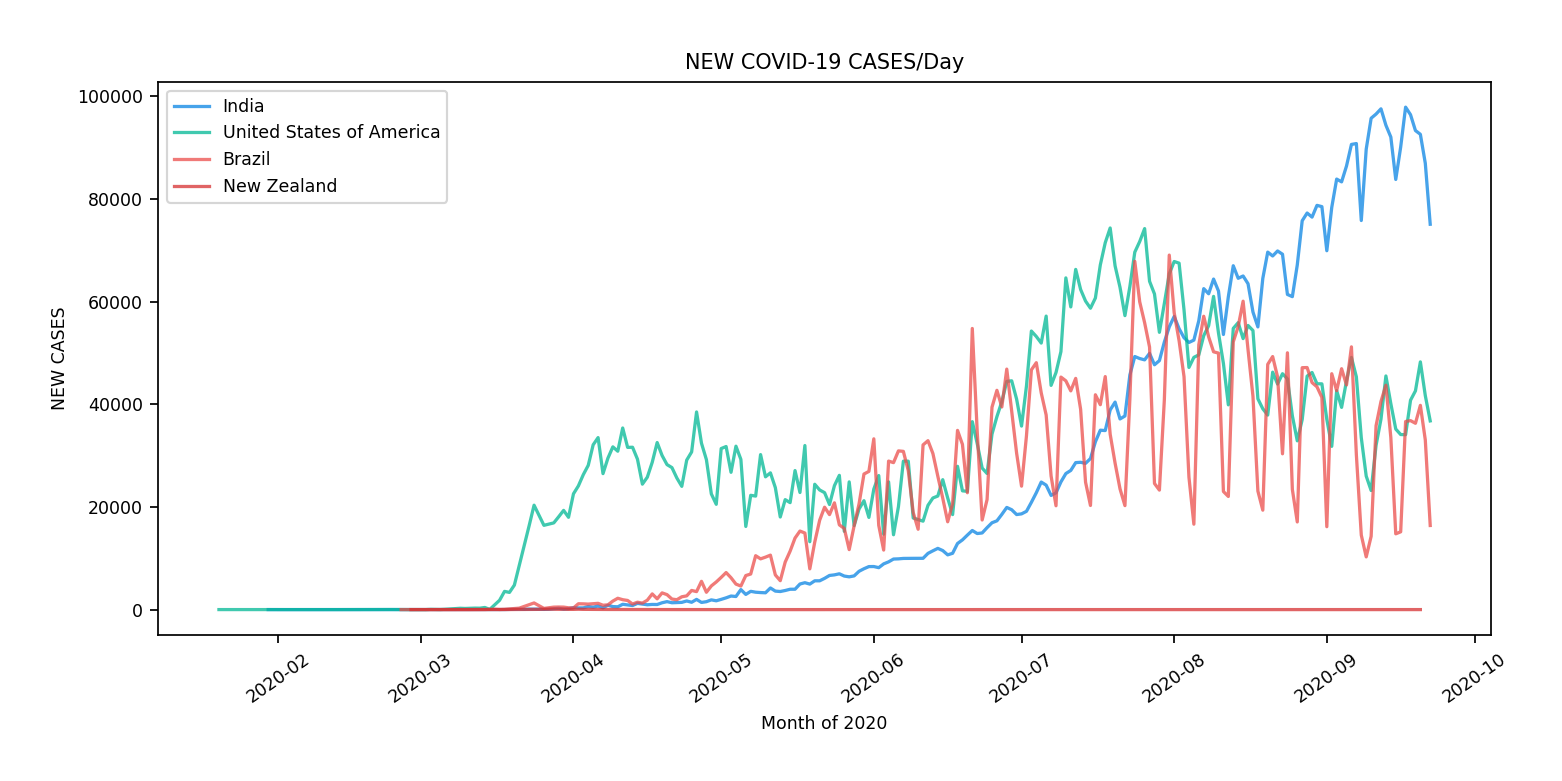

In [287]:
plot_data(countries = ['India', 'United States of America', 'Brazil', 'New Zealand'], plot = 'new cases', plot_type = 'line')

<IPython.core.display.Javascript object>


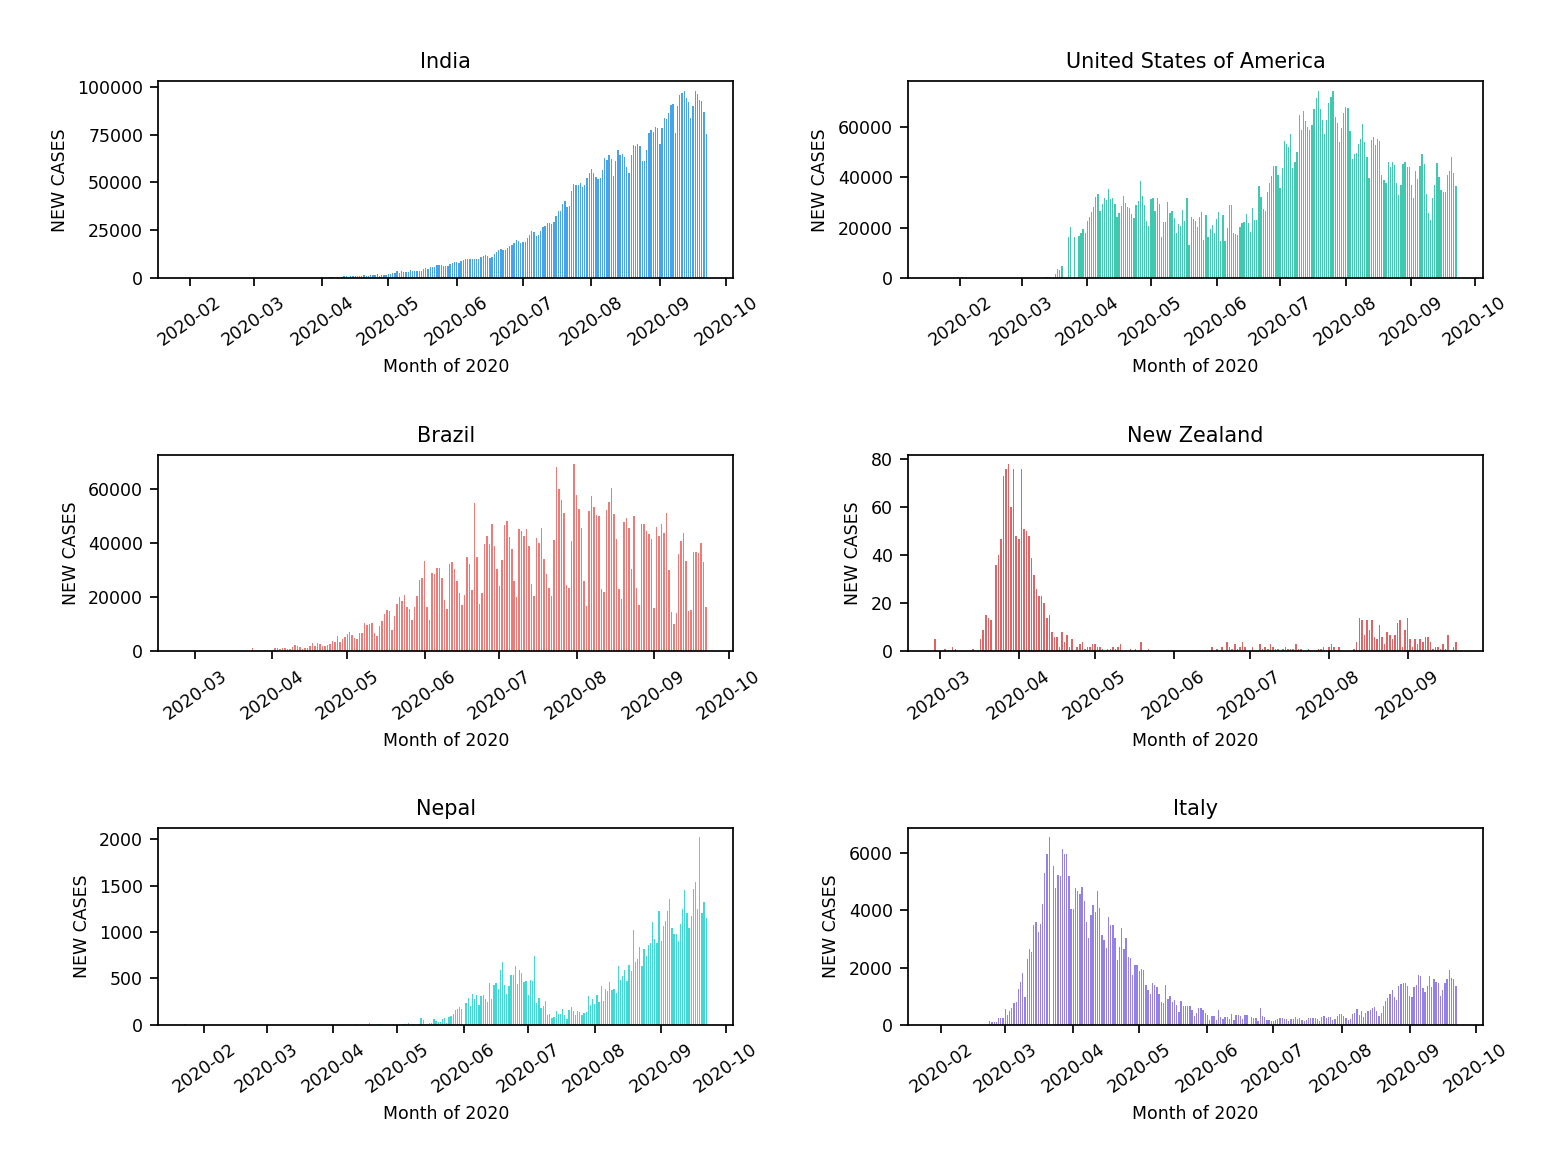

In [276]:
plot_data(countries = ['India', 'United States of America', 'Brazil', 'New Zealand', 'Nepal', 'Italy'], plot = 'new cases', plot_type = 'bar')

<IPython.core.display.Javascript object>


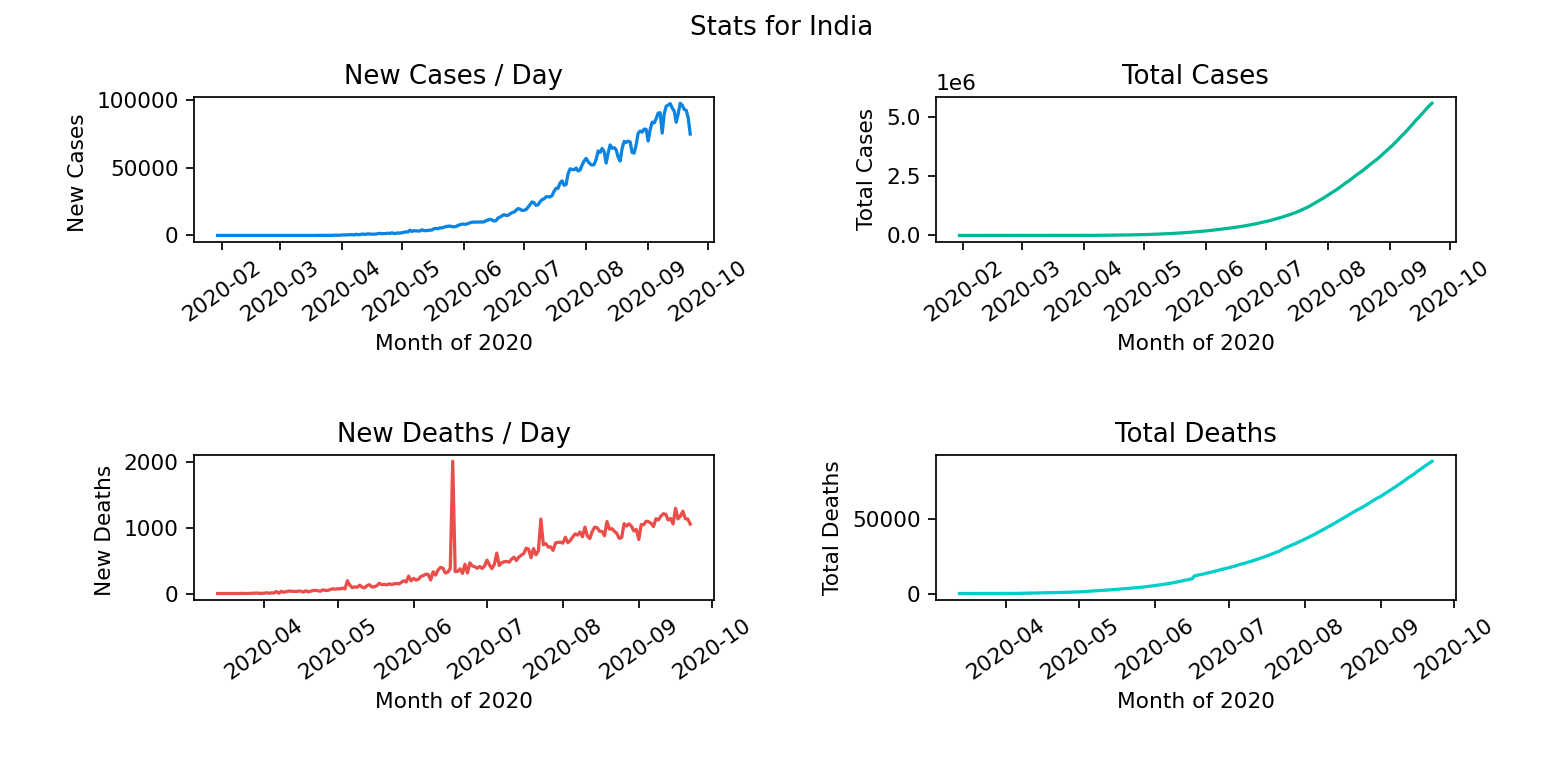

In [17]:
plot_all_data_for_a_country('India', 'line')

<IPython.core.display.Javascript object>


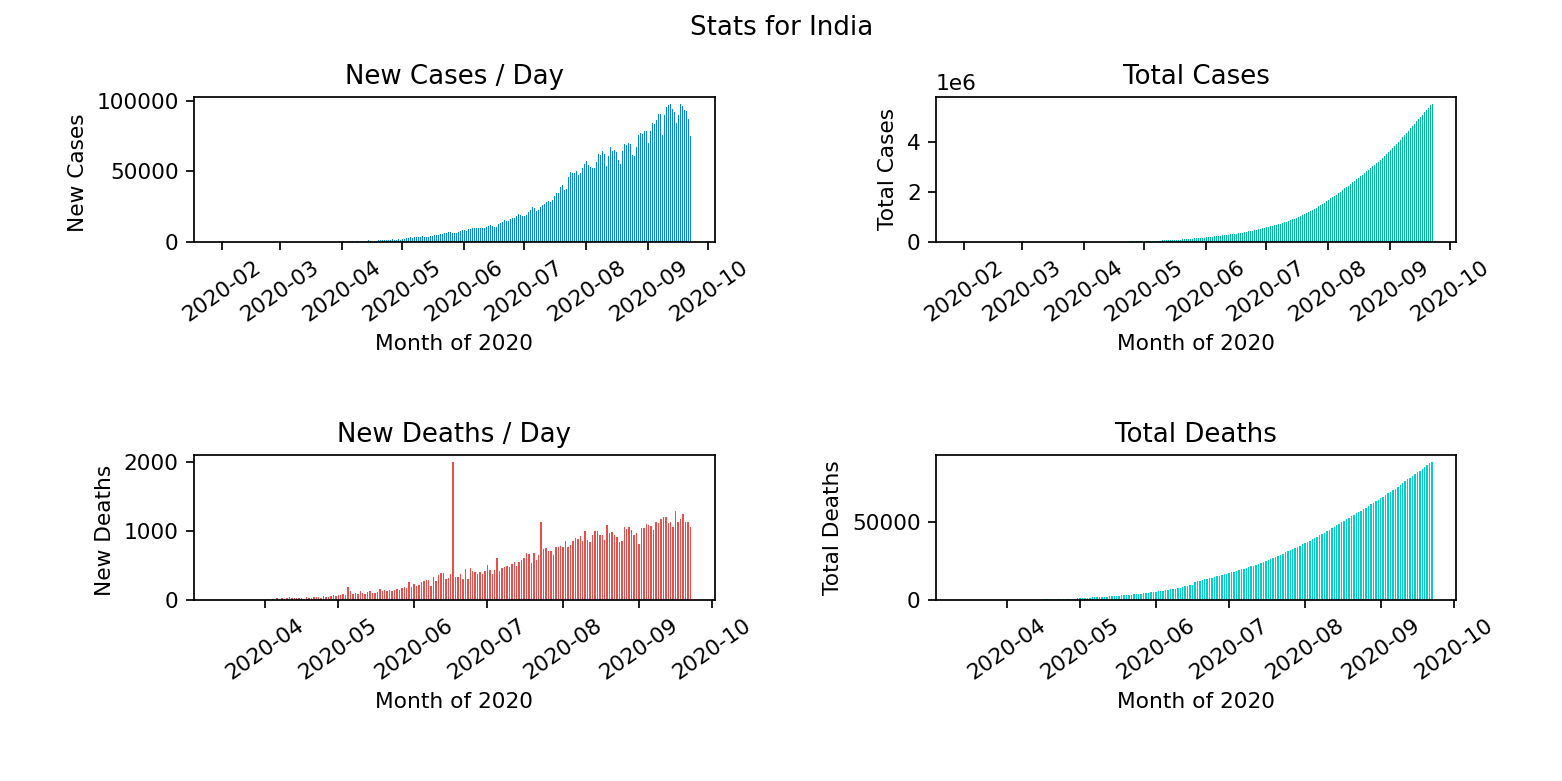

In [18]:
plot_all_data_for_a_country('India', 'bar')

<IPython.core.display.Javascript object>


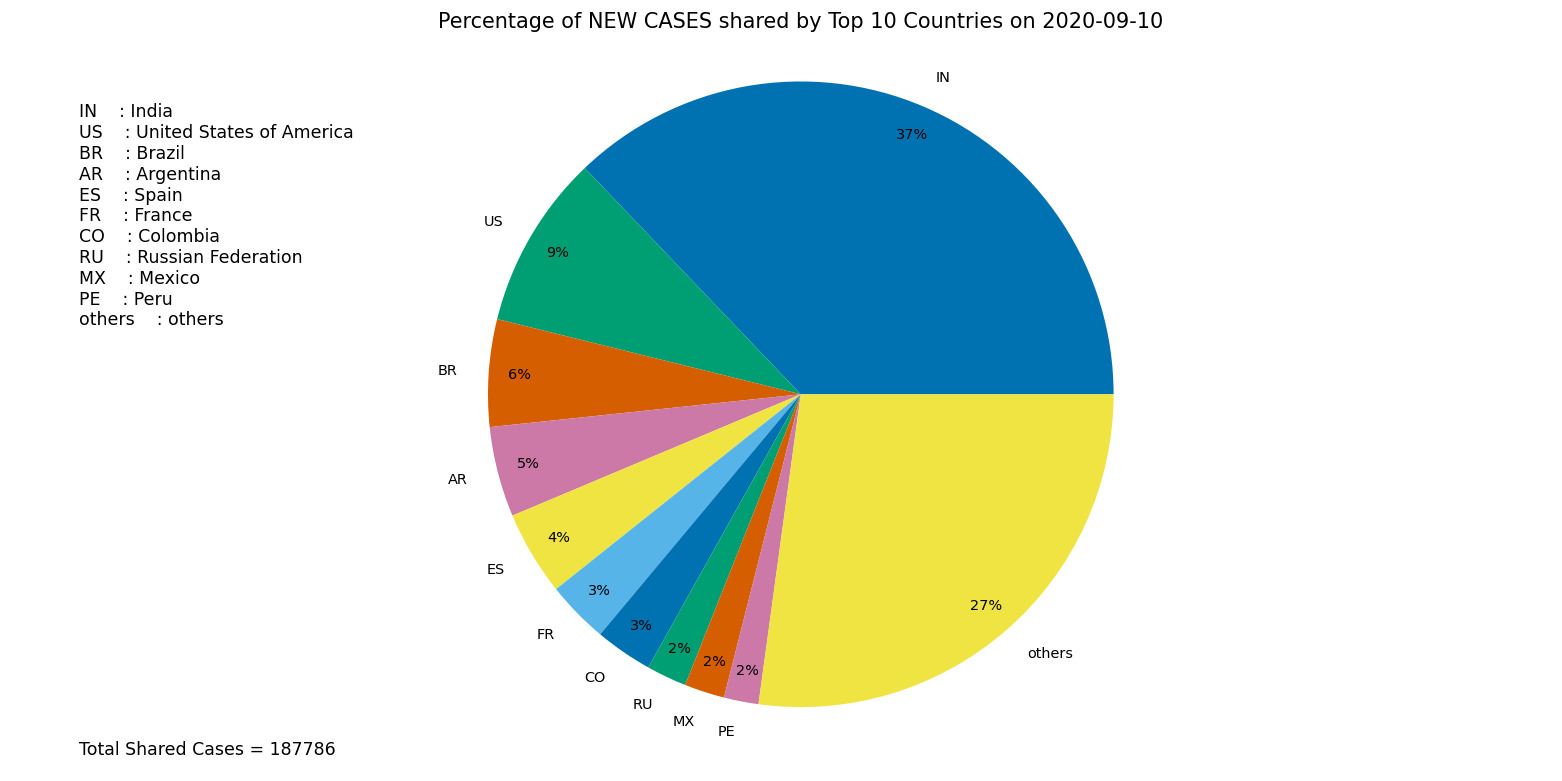

In [289]:
# plots percentage of total cases/new cases/total deaths etc shared by the top 10 countries on a certain day
# top countries = countries that had the most cases/ deaths etc on a certain day

plot_pie('2020-09-10', 'new cases')

['total cases', 'new cases', 'total deaths', 'new deaths']


<IPython.core.display.Javascript object>


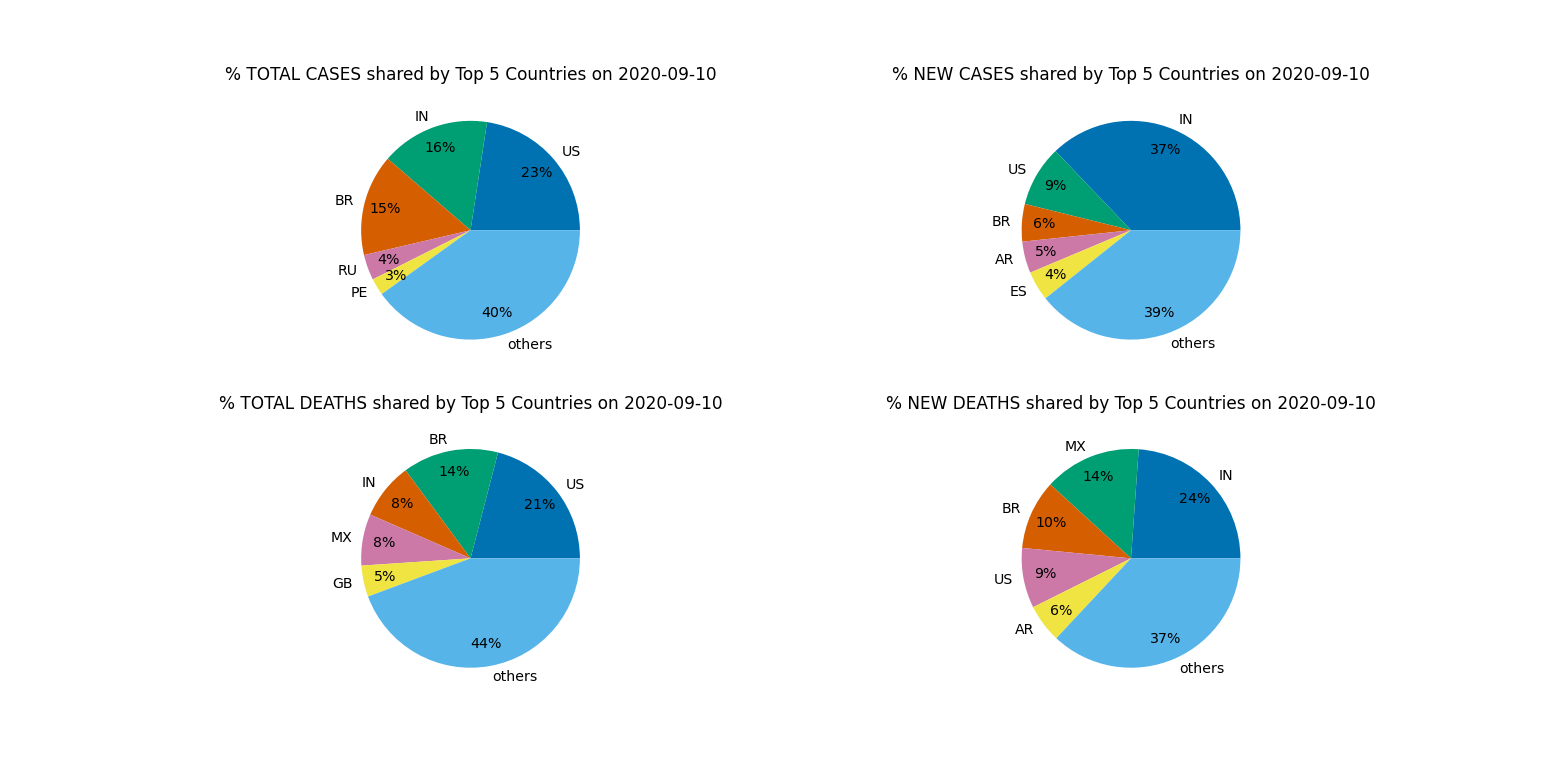

In [290]:
# plots percentage of ['total cases', 'new cases', 'total deaths', 'new deaths'] for top 5 countries on a certain day

plot_pie('2020-09-10', all_plots = True)

In [6]:
df[' New_cases'].sum()

31174627

In [31]:
asiaprob = df.groupby('WHO_region').get_group('EMRO')
# asiaprob.columns
asiaprob.set_index('Country', inplace = True)
asiaprob.loc['Yemen']

,Date,Country_code,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
Country,,,,,,,
Yemen,2020-01-03,YE,EMRO,0,0,0,0
Yemen,2020-01-04,YE,EMRO,0,0,0,0
Yemen,2020-01-05,YE,EMRO,0,0,0,0
Yemen,2020-01-06,YE,EMRO,0,0,0,0
Yemen,2020-01-07,YE,EMRO,0,0,0,0
...,...,...,...,...,...,...,...
Yemen,2020-09-18,YE,EMRO,3,2026,2,586
Yemen,2020-09-19,YE,EMRO,2,2028,0,586
Yemen,2020-09-20,YE,EMRO,2,2030,0,586
